In [1]:
import pandas as pd
import numpy
import torch 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import sys
sys.path.append("..")
from utils import pad_collate
from dataloader_comma import CommaDataset
from dataloader_nuscenes import NUScenesDataset
from model import VTN
import matplotlib.pyplot as plt 
from PIL import Image
import glob
import os
from utils import * 
import re
gpu_num = 1
multitask = 'distance'
backbone = 'none'
concept_features = True

/home/jessica/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
commda_ds = CommaDataset(dataset_type="test",
        multitask="distance",
        ground_truth="normal", dataset_path='/data1/jessica/data/toyota/')
nuscenes_ds = NUScenesDataset(dataset_type="test",
        multitask="distance",
        ground_truth="normal", dataset_path='/data1/jessica/data/toyota/' )
dataloader_comma = DataLoader(commda_ds, batch_size=1, shuffle=False, num_workers=0, collate_fn=pad_collate)
dataloader_nuscenes = DataLoader(nuscenes_ds, batch_size=1, shuffle=False, num_workers=0, collate_fn=pad_collate)

In [3]:
def get_regular_ckpt_from_lightning_checkpoint(state_dict):
    for key in list(state_dict.keys()):
        oldkey = key
        if oldkey[0:6] == 'model.':
            key = oldkey[6:]
            state_dict[key] = state_dict.pop(oldkey)
    return state_dict

In [4]:
model = VTN(multitask=multitask, backbone=backbone, concept_features=concept_features, device = f"cuda:{gpu_num}", return_concepts=True)
checkpoint_path = '/data1/jessica/data/toyota/ckpts_final/ckpts_final_comma_distance_none/lightning_logs/version_0/checkpoints//epoch=50-step=3162.ckpt'
ckpt = torch.load(checkpoint_path, map_location=f'cuda:{gpu_num}')
state_dict = ckpt['state_dict']
state_dict = get_regular_ckpt_from_lightning_checkpoint(state_dict)
model.load_state_dict(state_dict)
model.eval()
model = model.to(f'cuda:{gpu_num}')

using concept features


In [5]:
for batch in dataloader_comma:
    _, image_array, vego, angle, distance, m_lens, i_lens, s_lens, a_lens, d_lens = batch
    img = image_array[:, 0:30]
    img = img.to(f'cuda:{gpu_num}')
    angle = angle[:, 0:30].to(f'cuda:{gpu_num}')
    distance = distance[:, 0:30].to(f'cuda:{gpu_num}')
    vego = vego[:, 0:30].to(f'cuda:{gpu_num}')
    (logits, attns), concepts = model(img, angle, distance, vego)
    s = img.shape#[batch_size, seq_len, h,w,c]
    angle = angle.to("cpu")
    distance = distance.to("cpu")
    vego = vego.to("cpu")
    logits = logits.detach().cpu().to("cpu")
    attns = attns.detach().cpu().to("cpu")
    concepts = concepts.detach().cpu().to("cpu")
    break

OutOfMemoryError: CUDA out of memory. Tried to allocate 194.00 MiB (GPU 1; 23.69 GiB total capacity; 12.37 GiB already allocated; 22.62 MiB free; 12.85 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [13]:
concepts.shape, logits.shape, attns[0][:,:,0:concepts.shape[1]].shape, attns[1][:,:,0:concepts.shape[1]].shape , attns[2][:,:,0:concepts.shape[1]].shape

(torch.Size([1, 69, 643]),
 torch.Size([1, 69, 1]),
 torch.Size([1, 1, 69, 10]),
 torch.Size([1, 1, 69, 10]),
 torch.Size([1, 1, 69, 10]))

In [50]:
attns[0].shape

torch.Size([1, 1, 80, 10])

In [7]:
img = image_array[:, 0:5, :, :].to(f'cuda:{gpu_num}')

In [8]:
scenarios_tokens = scenarios_tokens.to(f'cuda:{gpu_num}')

In [9]:
logits_per_image, logits_per_text = clip_model(img.reshape((img.shape[0]*img.shape[1], img.shape[2], img.shape[3], img.shape[4])), scenarios_tokens)
probs = logits_per_image.softmax(dim=-1)
probs = logits_per_image.detach().reshape((int(img.shape[0]), int(logits_per_image.shape[0]/img.shape[0]), -1))


In [66]:
att = attns[0][:,:,0:concepts.shape[1]].detach()
seq_len = att.shape[2]

In [87]:
def moving_average(signal, window_size):
    window = np.ones(window_size) / window_size
    smoothed_signal = np.convolve(signal, window, mode='same')
    return smoothed_signal

In [81]:

def get_aligned_attention(attention):
    attention = attention[:, 1:-1]
    sequence_length = seq_len
    window_size = 8
    overlap = 4
    global_attended_token = 1
    padding_tokens = 8
    # Calculate the number of chunks
    number_of_chunks = np.ceil((sequence_length - window_size + overlap + 1) / (window_size - overlap)).astype(int)

    # Create an empty alignment array
    alignment_array = np.zeros((sequence_length + 2 * window_size , sequence_length + 2 * window_size), dtype=float)

    # Iterate over each chunk and extract attended token index
    for chunk_idx in range(number_of_chunks):
        # Calculate the start and end indices of the chunk
        start_index = chunk_idx * (window_size - overlap)
        end_index = start_index + window_size
        alignment_array[chunk_idx, start_index:end_index] = attention[chunk_idx]
    return alignment_array



In [82]:
atten = att

In [90]:
alignment_array.shape

(85, 85)

In [96]:
alignment_array = get_aligned_attention(atten.squeeze().cpu())
speed_graph = alignment_array.sum(axis=0)[8:-8]
speed_graph = moving_average(speed_graph, 5)

In [97]:
# Assuming you have a speed graph as a 1D array
for i, image in enumerate(image_array[0]): 
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

    # Assuming you have an image frame
    image_frame = image.permute(1,2,0)

    # Display the image frame
    ax1.imshow(image_frame)
    ax1.set_title("Image Frame")

    # Generate x-axis values for the speed graph
    x = np.arange(len(speed_graph))

    # Plot the speed graph
    ax2.plot(x, speed_graph)
    ax2.set_title("Speed Graph")

    # Choose a specific time and corresponding speed value to display
    time_step = i
    speed_value = speed_graph[time_step]

    # Add text annotation to the plot at the specified time step
    ax2.plot(time_step, speed_value, marker='o', markersize=10, color='r')

    # Adjust the plot layout if necessary
    plt.tight_layout()

    # Show the plot
    plt.savefig(f"/home/jessica/personalized_driving_toyota/result_images/attention/{i}.png")
    plt.clf()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

In [24]:
def extract_number(filename):
        match = re.search(r'\d+', filename)
        return int(match.group()) if match else -1

In [25]:
# Set the path to the directory containing the images
image_directory = '/home/jessica/personalized_driving_toyota/result_images/attention'

# Set the output GIF file path
output_gif_path = '/home/jessica/personalized_driving_toyota/result_images/attention.gif'

# Set the duration (in milliseconds) for each frame in the GIF
frame_duration = 800

# Get a sorted list of image files in the directory
image_files = sorted(glob.glob(f'{image_directory}/*.png'), key=extract_number)  # Adjust the file extension if necessary

# Create a list to store the frames of the GIF
frames = []

# Iterate over each image file
for image_file in image_files:
    # Open the image file
    image = Image.open(image_file)

    # Add the image to the list of frames
    frames.append(image)

# Save the frames as a GIF
frames[0].save(output_gif_path, format='GIF', append_images=frames[1:], save_all=True,
               duration=frame_duration, loop=0)


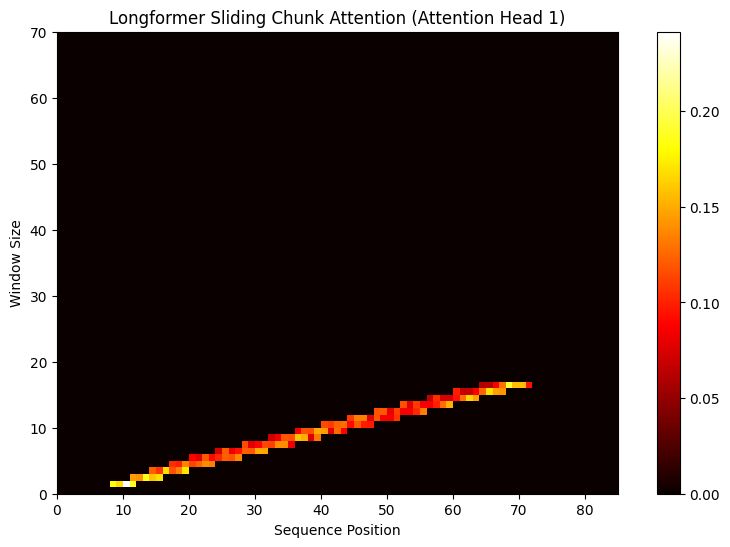

In [93]:
attention_weights = att
normalized_weights = attention_weights#np.array(attention_weights) / np.sum(attention_weights)

fig, ax = plt.subplots(figsize=(10, 6))
heatmap = ax.pcolormesh(alignment_array[0:70, :], cmap='hot')
ax.set_aspect('equal')
# Add colorbar
cbar = plt.colorbar(heatmap)

# Add labels and title
ax.set_xlabel('Sequence Position')
ax.set_ylabel('Window Size')
ax.set_title('Longformer Sliding Chunk Attention (Attention Head 1)')

# Show the plot
plt.show()



In [4]:
def mse_loss(input, target, mask, reduction="mean"):
        out = (input[~mask]-target[~mask])**2
        return out.mean() if reduction == "mean" else out 

In [5]:

p = '/data1/jessica/data/toyota/ckpts_final/'

experiments = os.listdir(p)
res = {}
res_ckpt = {}
for elem in experiments:
    path = p + elem + "/lightning_logs/" 
    versions =[ elem[-1 ]for elem in os.listdir(path)]
    versions = sorted(versions)
    version = f"version_{versions[-1]}"
    print(version, os.listdir(path))
    checkpoint_path = path + version + "/checkpoints/"
    if "checkpoints" not in os.listdir(path + version): continue
    files = os.listdir(checkpoint_path)

    task = []
    ckpt = []
    for filename in files: 
        if filename.endswith(".csv"):
            df = pd.read_csv(checkpoint_path + filename)
            df.columns = ['preds', 'targets']
            m = (df['targets'] > 50).astype(bool) | (df['targets'] == 0).astype(bool) 
            
            loss3 = torch.sqrt(mse_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m)))
            task.append(loss3.item())
        if filename.endswith(".ckpt"):
            ckpt.append(checkpoint_path + '/' + filename)
    res[elem] = task
    res_ckpt[elem] = ckpt


version_0 ['version_0']
version_0 ['version_0']
version_5 ['version_4', 'version_5']
version_2 ['version_0', 'version_2', 'version_1']
version_4 ['version_4', 'version_3']
version_0 ['version_0']
version_0 ['version_0']
version_7 ['version_4', 'version_3', 'version_6', 'version_7', 'version_2', 'version_1', 'version_5']
version_2 ['version_0', 'version_2', 'version_1']
version_4 ['version_4', 'version_3', 'version_0', 'version_2']
version_5 ['version_4', 'version_3', 'version_2', 'version_5']
version_6 ['version_4', 'version_3', 'version_6', 'version_2', 'version_1', 'version_5']
version_0 ['version_0']
version_5 ['version_4', 'version_5']
version_2 ['version_2', 'version_1']
version_0 ['version_0']
version_0 ['version_0']
version_1 ['version_0', 'version_1']
version_7 ['version_4', 'version_3', 'version_6', 'version_0', 'version_7', 'version_1', 'version_5']
version_0 ['version_0']
version_8 ['version_7', 'version_8']
version_1 ['version_1']
version_4 ['version_4']
version_2 ['version

In [6]:
res

{'ckpts_final_comma_distance_resnet': [4.665587373198741],
 'ckpts_final_comma_multitask_none': [3.3693716510452907, 4.579165410378686],
 'ckpts_final_nuscenes_multitask_resnet': [],
 'ckpts_final_comma_multitask_resnet': [4.987273033355811, 2.832363118532193],
 'ckpts_final_comma_angle_resnet': [3.1649969769178874],
 'ckpts_final_nuscenes_multitask_vit': [],
 'ckpts_final_nuscenes_multitask_clip': [],
 'ckpts_final_nuscenes_angle_none': [],
 'ckpts_final_comma_distance_none': [3.3851383559744126],
 'ckpts_final_nuscenes_angle_clip': [],
 'ckpts_final_nuscenes_distance_clip': [],
 'ckpts_final_comma_multitask_vit': [4.923400746465994, 2.9565217244374127],
 'ckpts_final_comma_multitask_clip': [],
 'ckpts_final_nuscenes_distance_none': [],
 'ckpts_final_comma_angle_none': [5.155869130660418],
 'ckpts_final_nuscenes_distance_resnet': [28.18212454012493],
 'ckpts_final_comma_angle_clip': [],
 'ckpts_final_comma_distance_vit': [5.023062603070098]}

In [23]:
res_ckpt

{'ckpts_final_comma_distance_resnet': ['/data1/jessica/data/toyota/ckpts_final/ckpts_final_comma_distance_resnet/lightning_logs/version_0/checkpoints//epoch=30-step=3844.ckpt',
  '/data1/jessica/data/toyota/ckpts_final/ckpts_final_comma_distance_resnet/lightning_logs/version_0/checkpoints//epoch=16-step=2108.ckpt'],
 'ckpts_final_comma_multitask_none': ['/data1/jessica/data/toyota/ckpts_final/ckpts_final_comma_multitask_none/lightning_logs/version_0/checkpoints//epoch=66-step=4154.ckpt',
  '/data1/jessica/data/toyota/ckpts_final/ckpts_final_comma_multitask_none/lightning_logs/version_0/checkpoints//epoch=72-step=4526.ckpt'],
 'ckpts_final_nuscenes_angle_vit': ['/data1/jessica/data/toyota/ckpts_final/ckpts_final_nuscenes_angle_vit/lightning_logs/version_4/checkpoints//epoch=169-step=23630.ckpt',
  '/data1/jessica/data/toyota/ckpts_final/ckpts_final_nuscenes_angle_vit/lightning_logs/version_4/checkpoints//epoch=168-step=23491.ckpt'],
 'ckpts_final_nuscenes_multitask_resnet': ['/data1/jes